![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Names with a Character-Level RNN

[In the last tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify names into their language of origin. This time we'll turn around and generate names from languages.

```
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

We are still hand-making a RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a "language model".

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb)
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

I also suggest the previous tutorial, [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb)

# Preparing the Data

See the last tutorial for more detail of this process. In short, there are a bunch of plain text files `data/names/[Language].txt` with a name per line. We split lines into an array, convert Unicode to ASCII, and end up with a dictionary `{language: [names ...]}`.

In [1]:
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('../data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


# Creating the Network

This network extends [the last tutorial's RNN](#Creating-the-Network) with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer `o2o` (after combining hidden and output) to give it more muscle to work with. There's also a dropout layer, which [randomly zeros parts of its input](https://arxiv.org/abs/1207.0580) with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

![](https://i.imgur.com/jzVrf7f.png)

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

# Preparing for Training

First of all, helper functions to get random pairs of (category, line):

In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Create training pair (category, line)
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the inputs of the network will be `(category, current letter, hidden state)` and the outputs will be `(next letter, next hidden state)`. So for each training set, we'll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for `"ABCD<EOS>"` we would create ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot tensor](https://en.wikipedia.org/wiki/One-hot) of size `<1 x n_categories>`. When training we just keep feeding it to the network at every timestep.

In [4]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor o of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience we'll also make a `randomTrainingSet` function that fetches a random pair and turns them into all the tensors needed for a training iteration.

In [5]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingSet():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

# Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step. The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

Training is business as usual - call train a bunch of times and wait a few minutes.

In [7]:
import time
import math

rnn = RNN(n_letters, 128, n_letters)

n_epochs = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

for epoch in range(1, n_epochs + 1):
    output, loss = train(*randomTrainingSet())
    total_loss += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%) 3.3556
0m 25s (10000 10%) 2.2885
0m 38s (15000 15%) 2.5487
0m 53s (20000 20%) 2.3268
1m 7s (25000 25%) 2.4397
1m 22s (30000 30%) 2.7498
1m 35s (35000 35%) 3.1376
1m 49s (40000 40%) 2.3080
2m 2s (45000 45%) 1.4830
2m 17s (50000 50%) 2.7544
2m 31s (55000 55%) 3.1911
2m 45s (60000 60%) 1.4745
2m 59s (65000 65%) 2.2205
3m 12s (70000 70%) 2.8517
3m 26s (75000 75%) 3.4358
3m 39s (80000 80%) 2.1085
3m 54s (85000 85%) 2.3308
4m 7s (90000 90%) 2.2968
4m 20s (95000 95%) 2.2569
4m 33s (100000 100%) 1.2370


# Plotting the Network

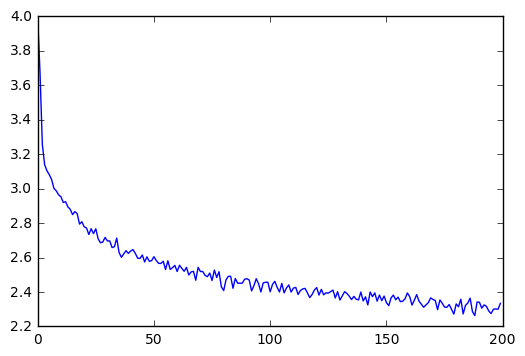

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token. Another strategy would have been to include a "start of string" token in training and start from there.

In [9]:
def sample(target_category, start_letter='A'):
    target_category = Variable(categoryTensor(target_category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter
    
    for i in range(10):
        output, hidden = rnn(target_category, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:    
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

def samples(target_category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(target_category, start_letter))

In [10]:
samples('Russian', 'RUS')

Roverik
Uanter
Shinakov


In [11]:
samples('German', 'GER')

Gerter
Erimer
Romer


In [12]:
samples('Spanish', 'SPA')

Sander
Palla
Aller


In [13]:
samples('Chinese', 'CHI')

Chan
Han
Iun


# Exercises

* Use random sampling (rather than top 1) to output a variety of names when sampling.
* Use a "start of sentence" token so that sampling can be done without extra input.
* Extend the network to more layers, or use a proven shape like LSTM or GRU.